# **Identifying Key Entities in Recipe Data**


**Business Objective**:
The goal of this assignment is to train a Named Entity Recognition (NER) model using Conditional Random Fields (CRF) to extract key entities from recipe data. The model will classify words into predefined categories such as ingredients, quantities and units, enabling the creation of a structured database of recipes and ingredients that can be used to power advanced features in recipe management systems, dietary tracking apps, or e-commerce platforms.

### **Data Description**
The given data is in JSON format, representing a **structured recipe ingredient list** with **Named Entity Recognition (NER) labels**. Below is a breakdown of the data fields:

```json
[
    {
        "input": "6 Karela Bitter Gourd Pavakkai Salt 1 Onion 3 tablespoon Gram flour besan 2 teaspoons Turmeric powder Haldi Red Chilli Cumin seeds Jeera Coriander Powder Dhania Amchur Dry Mango Sunflower Oil",
        "pos": "quantity ingredient ingredient ingredient ingredient ingredient quantity ingredient quantity unit ingredient ingredient ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient"
    },
    {
      "input": "2-1/2 cups rice cooked 3 tomatoes teaspoons BC Belle Bhat powder 1 teaspoon chickpea lentils 1/2 cumin seeds white urad dal mustard green chilli dry red 2 cashew or peanuts 1-1/2 tablespoon oil asafoetida",
      "pos": "quantity unit ingredient ingredient quantity ingredient unit ingredient ingredient ingredient ingredient quantity unit ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity unit ingredient ingredient"
    }
]


| **Key**  | **Description**  |
|----------|-----------------|
| `input`  | Contains a raw ingredient list from a recipe. |
| `pos`    | Represents the corresponding part-of-speech (POS) tags or NER labels, identifying quantities, ingredients, and units. |


## **1** Import libraries

#### **1.1** Installation of sklearn-crfsuite

sklearn-crfsuite is a Python wrapper for CRFsuite, a fast and efficient implementation of Conditional Random Fields (CRFs). It is designed to integrate seamlessly with scikit-learn for structured prediction tasks such as Named Entity Recognition (NER), Part-of-Speech (POS) tagging, and chunking.

In [1]:
# installation of sklearn_crfsuite
!pip install sklearn_crfsuite==0.5.0

#### **1.2** Import necessary libraries

In [2]:
# Import warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Import necessary libraries
import json  # For handling JSON data
import pandas as pd  # For data manipulation and analysis
import re  # For regular expressions (useful for text preprocessing)
import matplotlib.pyplot as plt  # For visualisation
import seaborn as sns  # For advanced data visualisation
import sklearn_crfsuite  # CRF (Conditional Random Fields) implementation for sequence modeling
import numpy as np  # For numerical computations
# Saving and loading machine learning models
import joblib
import random
import spacy
from IPython.display import display, Markdown # For displaying well-formatted output

from fractions import Fraction  # For handling fractional values in numerical data
# Importing tools for feature engineering and model training
from collections import Counter  # For counting occurrences of elements in a list
from sklearn.model_selection import train_test_split  # For splitting dataset into train and test sets
from sklearn_crfsuite import metrics  # For evaluating CRF models
from sklearn_crfsuite.metrics import flat_classification_report
from sklearn.utils.class_weight import compute_class_weight
from collections import Counter
from sklearn.metrics import confusion_matrix

In [4]:
# Ensure pandas displays full content
pd.set_option('display.max_colwidth', None)
pd.set_option('display.expand_frame_repr', False)

## **2** Data Ingestion and Preparation <font color = red>[25 marks]</font> <br>

#### **2.1** *Read Recipe Data from Dataframe and prepare the data for analysis* <font color = red>[12 marks]</font> <br>
Read the data from JSON file, print first five rows and describe the dataframe

##### **2.1.1** **Define a *load_json_dataframe* function** <font color = red>[7 marks]</font> <br>

Define a function that takes path of the ingredient_and_quantity.json file and reads it, convert it into dataframe - df and return it.

In [5]:
# define a function to load json file to a dataframe

def load_json_dataframe(file_path):
    with open(file_path, 'r') as file:
        data = json.load(file)
    df = pd.DataFrame(data)
    return df

##### **2.1.2** **Execute the *load_json_dataframe* function** <font color = red>[2 marks]</font> <br>

In [7]:
# read the json file by giving the file path and create a dataframe

file_path = "/home/raghavendra/Downloads/Starter+Notebook+++Data/ingredient_and_quantity.json"
df = load_json_dataframe(file_path)



##### **2.1.3** **Describe the dataframe** <font color = red>[3 marks]</font> <br>

Print first five rows of dataframe along with dimensions. Display the information of dataframe

In [8]:
# display first five rows of the dataframe - df
df.head()

input                                                                                                                                                                                                                                                                                                                                                                                                                                                                      pos
0                                                                                                 6 Karela Bitter Gourd Pavakkai Salt 1 Onion 3 tablespoon Gram flour besan 2 teaspoons Turmeric powder Haldi Red Chilli Cumin seeds Jeera Coriander Powder Dhania Amchur Dry Mango Sunflower Oil                                                                                                                                         quantity ingredient ingredient ingredient ingredient ingredient quantity ingredient quantity unit ingredient ingredient ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient
1                                                                                    2-1/2 cups rice cooked 3 tomatoes teaspoons BC Belle Bhat powder 1 teaspoon chickpea lentils 1/2 cumin seeds white urad dal mustard green chilli dry red 2 cashew or peanuts 1-1/2 tablespoon oil asafoetida                                                                                                                        quantity unit ingredient ingredient quantity ingredient unit ingredient ingredient ingredient ingredient quantity unit ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity unit ingredient ingredient
2                                                                  1-1/2 cups Rice Vermicelli Noodles Thin 1 Onion sliced 1/2 cup Carrots Gajjar chopped 1/3 Green peas Matar 2 Chillies 1/4 teaspoon Asafoetida hing Mustard seeds White Urad Dal Split Ghee sprig Curry leaves Salt Lemon juice                                                                                       quantity unit ingredient ingredient ingredient ingredient quantity ingredient ingredient quantity unit ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient unit ingredient ingredient ingredient ingredient ingredient
3  500 grams Chicken 2 Onion chopped 1 Tomato 4 Green Chillies slit inch Ginger finely 6 cloves Garlic 1/2 teaspoon Turmeric powder Haldi Garam masala tablespoon Sesame Gingelly Oil 1/4 Methi Seeds Fenugreek Coriander Dhania Dry Red Fennel seeds Saunf cups Sorrel Leaves Gongura picked and  quantity unit ingredient quantity ingredient ingredient quantity ingredient quantity ingredient ingredient ingredient unit ingredient ingredient quantity unit ingredient quantity unit ingredient ingredient ingredient ingredient ingredient unit ingredient ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient unit ingredient ingredient ingredient ingredient ingredient
4                                                                                                                                                           1 tablespoon chana dal white urad 2 red chillies coriander seeds 3 inches ginger onion tomato Teaspoon mustard asafoetida sprig curry                                                                                                                                                                                                                                                                 qua

In [9]:
# print the dimensions of dataframe - df
df.shape

(285, 2)

In [10]:
# print the information of the dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 285 entries, 0 to 284
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   input   285 non-null    object
 1   pos     285 non-null    object
dtypes: object(2)
memory usage: 4.6+ KB


#### **2.2** *Recipe Data Manipulation* <font color = red>[13 marks]</font> <br>
Create derived metrics in dataframe and provide insights of the dataframe

##### **2.2.1** **Create input_tokens and pos_tokens columns by splitting the input and pos from the dataframe** <font color = red>[3 marks]</font> <br>
Split the input and pos into input_tokens and pos_tokens in the dataframe and display it in the dataframe

In [11]:
# split the input and pos into input_tokens and pos_tokens in the dataframe

# Tokenize input
df['input_tokens'] = df['input'].str.split()
# Tokenize POS
df['pos_tokens'] = df['pos'].str.split()

In [12]:
# display first five rows of the dataframe - df
df.head(5)

input                                                                                                                                                                                                                                                                                                                                                                                                                                                                      pos                                                                                                                                                                                                                                                                                                                                   input_tokens                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              pos_tokens
0                                                                                                 6 Karela Bitter Gourd Pavakkai Salt 1 Onion 3 tablespoon Gram flour besan 2 teaspoons Turmeric powder Haldi Red Chilli Cumin seeds Jeera Coriander Powder Dhania Amchur Dry Mango Sunflower Oil                                                                                                                                         quantity ingredient ingredient ingredient ingredient ingredient quantity ingredient quantity unit ingredient ingredient ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient                                                                                                                [6, Karela, Bitter, Gourd, Pavakkai, Salt, 1, Onion, 3, tablespoon, Gram, flour, besan, 2, teaspoons, Turmeric, powder, Haldi, Red, Chilli, Cumin, seeds, Jeera, Coriander, Powder, Dhania, Amchur, Dry, Mango, Sunflower, Oil]                                                                                                                                                        [quantity, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, quantity, unit, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient]
1                                                                                    2-1/2 cups rice cooked 3 tomatoes teaspoons BC Belle Bhat powder 1 teaspoon chickpea lentils 1/2 cumin seeds white urad dal mustard green chilli dry red 2 cashew or peanuts 1-1/2 tablespoon oil asafoetida                                                                                                                        quantity unit ingredient ingredient quantity ingredient unit ingredient ingredient ingredient ingredient quantity unit ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity unit ingredient ingredient                                                                                                [2-1/2, cups, rice, cooked, 3, tomatoes, teaspoons, BC, Belle, Bhat, powder, 1, teaspoon, chickpea, lentils, 1/2, cumin, seeds, white, urad, dal, mustard, green, chilli, dry, red, 2, cashew, or, peanuts, 1-1/2, tablespoon, oil, asafoetida]                               

##### **2.2.2** **Provide the length for input_tokens and pos_tokens and validate their length** <font color = red>[2 marks]</font> <br>

Create input_length and pos_length columns in the dataframe and validate both the lengths. Check for the rows that are unequal in input and pos length


In [14]:
# create input_length and pos_length columns for the input_tokens and pos-tokens
df['input_length'] = df['input_tokens'].apply(len)
df['pos_length'] = df['pos_tokens'].apply(len)

In [15]:
# check for the equality of input_length and pos_length in the dataframe

df['lengths_match'] = df['input_length'] == df['pos_length']

# Print rows where the lengths do not match
mismatched_rows = df[~df['lengths_match']]
print("Rows with mismatched lengths:")
mismatched_rows


Rows with mismatched lengths:


input                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               pos                                                                                                                                                                                                                                                                                                                                                                                input_tokens                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              pos_tokens  input_length  pos_length  lengths_match
17                                                                                                                                                                                                                                                   2 cups curd 1 cup gourd cucumber green cor coriander 1/2 teaspoon cumin powder salt                                                                                                                                                                                                                                                                                                                                                                                                                 quantity unit ingredient quantity unit ingredient ingredient ingredient ingredient quantity unit ingredient ingredient ingredient                                                                                                                                                                                                                                                                                         [2, cups, curd, 1, cup, gourd, cucumber, green, cor, coriander, 1/2, teaspoon, cumin, powder, salt]                                                                                                                                                                                                                                                                                                                                                                                                                                                        [quantity, unit, ingredient, quantity, unit, ingredient, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient]            15          14          False
27                                                                                   1 Baguette sliced 1 1/2 tablespoon Butter 1/2 Garlic minced cup Spinach Leaves Palak Red Bell pepper Capsicum Tomato finely chopped Onion Black powder Italian seasoning teaspoon Fresh cream Cheddar cheese grated Salt Roasted tomato pasta sauce                                                                                                                                                               quantity ingredient ingredient quantity unit ingredient quantity ingredient ingredient unit ingredient ingre

##### **2.2.3** **Define a unique_labels function and validate the labels in pos_tokens** <font color = red>[2 marks]</font> <br>

Define a unique_labels function which checks for all the unique pos labels in the recipe & execute it.


In [16]:
# Define a unique_labels function to checks for all the unique pos labels in the recipe & print it

def unique_labels(df):
    all_labels = [label for sublist in df['pos_tokens'] for label in sublist]
    unique = set(all_labels)
    print("Unique POS labels:", unique)
    return unique

# Call the function
unique_labels(df)

Unique POS labels: {'ingredient', 'quantity', 'unit'}


{'ingredient', 'quantity', 'unit'}

##### **2.2.3** **Provide the insights seen in the recipe data after validation** <font color = red>[1 marks]</font> <br>

Provide the indexes that requires cleaning and formatting in the dataframe

<font color = red>[write your answer]</font> <br>

 * After checking the token lengths, I noticed that most rows are fine, but a few of them have mismatched input_tokens and pos_tokens. That means the number of words and labels don't match due to maybe there's a missing label or an extra word in the input.
 * Indexes that require cleaning: [17, 27, 79, 164, 207]


##### **2.2.4** **Drop the rows that have invalid data provided in previous cell** <font color = red> [2 marks]</font> <br>

In [18]:
# drop the irrelevant recipe data
df = df[df['input_length'] == df['pos_length']].reset_index(drop=True)


##### **2.2.5** **Update the input_length & pos_length in dataframe**<font color = red> [2 marks]</font> <br>

In [19]:
# update the input and pos length in input_length and pos_length

df['input_length'] = df['input_tokens'].apply(len)
df['pos_length'] = df['pos_tokens'].apply(len)

##### **2.2.6** **Validate the input_length and pos_length by checking unequal rows** <font color = red> [1 marks]</font> <br>

In [20]:
# validate the input length and pos length as input_length and pos_length
unequal_rows = df[df['input_length'] != df['pos_length']]
print("Rows with unequal input_length and pos_length:")
print(unequal_rows)

Rows with unequal input_length and pos_length:
Empty DataFrame
Columns: [input, pos, input_tokens, pos_tokens, input_length, pos_length, lengths_match]
Index: []


## **3** Train Validation Split (70 train - 30 val) <font color = red>[6 marks]</font> <br>

#### **3.1** *Perform train and validation split ratio* <font color = red>[6 marks]</font> <br>
Split the dataset with the help of input_tokens and pos_tokens and make a ratio of 70:30 split for training and validation datasets.

###### **3.1.1** **Split the dataset into train_df and val_df into 70:30 ratio** <font color = red> [1 marks]</font> <br>

In [21]:
# split the dataset into training and validation sets

train_df, val_df = train_test_split(df, test_size=0.3, random_state=42)

# Show sizes of splits
print("Training set size:", len(train_df))
print("Validation set size:", len(val_df))


Training set size: 196
Validation set size: 84


###### **3.1.2** **Print the first five rows of train_df and val_df** <font color = red> [1 marks]</font> <br>

In [22]:
# print the first five rows of train_df
train_df.head()

input                                                                                                                                                                                                                                                                                                                                                                                                                                       pos                                                                                                                                                                                                                                                                                           input_tokens                                                                                                                                                                                                                                                                                                                                                                                                                                                                          pos_tokens  input_length  pos_length  lengths_match
175                                                        250 grams Okra Oil 1 Onion finely chopped Tomato Grated teaspoon Ginger 2 Garlic Finely 1/2 Cumin seeds 1/4 Teaspoon asafoetida cup cottage cheese pinched coriander powder mango red chilli turmeric                                                                                                                        quantity unit ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient unit ingredient quantity ingredient ingredient quantity ingredient ingredient quantity unit ingredient unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient                                                                  [250, grams, Okra, Oil, 1, Onion, finely, chopped, Tomato, Grated, teaspoon, Ginger, 2, Garlic, Finely, 1/2, Cumin, seeds, 1/4, Teaspoon, asafoetida, cup, cottage, cheese, pinched, coriander, powder, mango, red, chilli, turmeric]                                                                                                                                  [quantity, unit, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, ingredient, ingredient, unit, ingredient, quantity, ingredient, ingredient, quantity, ingredient, ingredient, quantity, unit, ingredient, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient]            31          31           True
55   200 grams Paneer Homemade Cottage Cheese 2 Potato Aloo Bay leaf tej patta Dry Red Chilli 1 tablespoon Panch Phoran Masala roasted and powdered Tomato big sized teaspoon Turmeric powder Haldi Cumin seeds Jeera Ginger grated Salt 1/2 Sugar Sunflower Oil  quantity unit ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient  [200, grams, Paneer, Homemade, Cottage, Cheese, 2, Potato, Aloo, Bay, leaf, tej, patta, Dry, Red, Chilli, 1, tablespoon, Panch, Phoran, Masala, roasted, and, powdered, Tomato, big, sized, teaspoon, Turmeric, powder, Haldi, Cumin, seeds, Jeera, Ginger, grated, Salt, 1/2, Sugar, Sunflower, Oil]  [quantity, unit, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ing

In [23]:
# print the first five rows of the val_df
val_df.head()

input                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      pos                                                                                                                                                                                                                                                                                                                                                                                                                        input_tokens                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        pos_tokens  input_length  pos_length  lengths_match
33                                                                                                                                                                                                                                                                                       1 cup Ada 2 liter Milk 3/4 Sugar tablespoon Ghee 1/2 teaspoon Cardamom Powder Elaichi                                                                                                                                                                                                                                                                                                                                                                                                                                                     quantity unit ingredient quantity unit ingredient quantity ingredient unit ingredient quantity unit ingredient ingredient ingredient                                                                                                                                                                                                                                                                                                                               [1, cup, Ada, 2, liter, Milk, 3/4, Sugar, tablespoon, Ghee, 1/2, teaspoon, Cardamom, Powder, Elaichi]                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              [quantity, unit, ingredient, quantity, unit, ingredient, quantity, ingredient, unit, ingredient, quantity, unit, ingredient, ingredient, ingredient]            15          15           True
108  1 Carrot Gajjar chopped 7 Potatoes Aloo 2 cups Cauliflower gobi cut to small florets Onion tablespoon Ginger Garlic Paste Salt teaspoons Sunflower Oil 1/2 cup Fresh coconut grated teaspoon Whole Black Peppercorns Green Chillies Fennel seeds Saunf Poppy 6 Cashew nuts inch Cinnamon Stick Dalchini Star anise 3 C

###### **3.1.3** **Extract the dataset into train_df and val_df into X_train, X_val, y_train and y_val and display their length** <font color = red> [2 marks]</font> <br>

Extract X_train, X_val, y_train and y_val by extracting the list of input_tokens and pos_tokens from train_df and val_df and also display their length

In [24]:
# extract the training and validation sets by taking input_tokens and pos_tokens

X_train = train_df['input_tokens'].tolist()
y_train = train_df['pos_tokens'].tolist()

X_val = val_df['input_tokens'].tolist()
y_val = val_df['pos_tokens'].tolist()

In [25]:
# validate the shape of training and validation samples

print("Length of X_train:", len(X_train))
print("Length of y_train:", len(y_train))
print("Length of X_val:", len(X_val))
print("Length of y_val:", len(y_val))

Length of X_train: 196
Length of y_train: 196
Length of X_val: 84
Length of y_val: 84


###### **3.1.4** **Display the number of unique labels present in y_train** <font color = red> [2 marks]</font> <br>

In [26]:
# Display the number of unique labels present in y_train

all_labels = [label for sequence in y_train for label in sequence]
unique_labels = set(all_labels)

print("Unique labels in y_train:", unique_labels)
print("Number of unique labels in y_train:", len(unique_labels))


Unique labels in y_train: {'ingredient', 'quantity', 'unit'}
Number of unique labels in y_train: 3


## **4** Exploratory Recipe Data Analysis on Training Dataset <font color = red>[16 marks]</font> <br>

#### **4.1** *Flatten the lists for input_tokens & pos_tokens* <font color = red>[2 marks]</font> <br>

Define a function **flatten_list** for flattening the structure for input_tokens and pos_tokens. The input parameter passed to this function is a nested list.

Initialise the dataset_name with a value ***'Training'***




In [28]:
# flatten the list for nested_list (input_tokens, pos_tokens)

def flatten_list(nested_list):
    return [item for sublist in nested_list for item in sublist]


In [29]:
# initialise the dataset_name
dataset_name = 'Training'

#### **4.2** *Extract and validate the tokens after using the flattening technique* <font color = red>[2 marks]</font> <br>

Define a function named ***extract_and_validate_tokens*** with parameters dataframe and dataset_name (Training/Validation), validate the length of input_tokens and pos_tokens from dataframe and display first 10 records for both the input_tokens and pos_tokens. Execute this function




In [31]:
# define a extract_and_validate_tokens with parameters (df, dataset_name)
# call the flatten_list and apply it on input_tokens and pos_tokens
# validate their length and display first 10 records having input and pos tokens

def extract_and_validate_tokens(df, dataset_name):
    # Flatten input and pos tokens
    flat_input_tokens = flatten_list(df['input_tokens'].tolist())
    flat_pos_tokens = flatten_list(df['pos_tokens'].tolist())
    
    # Validate their lengths
    print(f"[{dataset_name}] Length of input_tokens:", len(flat_input_tokens))
    print(f"[{dataset_name}] Length of pos_tokens:", len(flat_pos_tokens))
    print(f"[{dataset_name}] Lengths Match:", len(flat_input_tokens) == len(flat_pos_tokens))
    
    # Display first 10 records
    print(f"\nFirst 10 input tokens ({dataset_name}):", flat_input_tokens[:10])
    print(f"First 10 pos tokens ({dataset_name}):", flat_pos_tokens[:10])
    
    return flat_input_tokens, flat_pos_tokens

# Execute the function on Training set
flat_input_train, flat_pos_train = extract_and_validate_tokens(train_df, 'Training')

[Training] Length of input_tokens: 7114
[Training] Length of pos_tokens: 7114
[Training] Lengths Match: True

First 10 input tokens (Training): ['250', 'grams', 'Okra', 'Oil', '1', 'Onion', 'finely', 'chopped', 'Tomato', 'Grated']
First 10 pos tokens (Training): ['quantity', 'unit', 'ingredient', 'ingredient', 'quantity', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient']


In [32]:
# extract the tokens and its pos tags
token_pos_pairs = list(zip(flat_input_train, flat_pos_train))
print("First 10 (token, POS tag) pairs:")
for token, tag in token_pos_pairs[:10]:
    print(f"Token: {token:<12} → POS Tag: {tag}")

First 10 (token, POS tag) pairs:
Token: 250          → POS Tag: quantity
Token: grams        → POS Tag: unit
Token: Okra         → POS Tag: ingredient
Token: Oil          → POS Tag: ingredient
Token: 1            → POS Tag: quantity
Token: Onion        → POS Tag: ingredient
Token: finely       → POS Tag: ingredient
Token: chopped      → POS Tag: ingredient
Token: Tomato       → POS Tag: ingredient
Token: Grated       → POS Tag: ingredient


#### **4.3** *Categorise tokens into labels (unit, ingredient, quantity)* <font color = red>[2 marks]</font> <br>

Define a function ***categorize_tokens*** to categorise tokens into ingredients, units and quantities by using extracted tokens in the previous code and return a list of ingredients, units and quantities. Execute this function to get the list.



In [34]:
# define a categorize_tokens function and provide the tokens and pos_tags as parameters and create ingredient, unit and quantity list and return it
# validate the list that it comprised of these labels, if not return empty arrays

# Define the function to categorize tokens by their labels
def categorize_tokens(tokens, pos_tags):
    ingredients = []
    units = []
    quantities = []
    
    # Validate lengths before proceeding
    if len(tokens) != len(pos_tags):
        print("Length mismatch! Returning empty lists.")
        return [], [], []

    # Categorize tokens based on pos_tags
    for token, tag in zip(tokens, pos_tags):
        if tag == 'ingredient':
            ingredients.append(token)
        elif tag == 'unit':
            units.append(token)
        elif tag == 'quantity':
            quantities.append(token)
    
    return ingredients, units, quantities



In [35]:
#  call the function to categorise the labels into respective list
ingredients, units, quantities = categorize_tokens(flat_input_train, flat_pos_train)

# Optionally, display some results
print("Sample Ingredients:", ingredients[:10])
print("Sample Units:", units[:10])
print("Sample Quantities:", quantities[:10])


Sample Ingredients: ['Okra', 'Oil', 'Onion', 'finely', 'chopped', 'Tomato', 'Grated', 'Ginger', 'Garlic', 'Finely']
Sample Units: ['grams', 'teaspoon', 'Teaspoon', 'cup', 'grams', 'tablespoon', 'teaspoon', 'grams', 'teaspoon', 'sprig']
Sample Quantities: ['250', '1', '2', '1/2', '1/4', '200', '2', '1', '1/2', '500']


#### **4.4** *Top 10 Most Frequent Items* <font color = red>[3 marks]</font> <br>

Define a function ***get_top_frequent_items*** to display top 10 most frequent items

Here, item_list is used as a general parameter where you will call this function for ingredient and unit list

Execute this function separately for top 10 most units and ingredients



In [36]:
# define a function get_top_frequent_items to get the top frequent items by using item_list, pos label and dataset_name(Training/Validation) and return top items

def get_top_frequent_items(item_list, label, dataset_name):
    counter = Counter(item_list)
    top_items = counter.most_common(10)
    
    print(f"\nTop 10 most frequent {label}s in {dataset_name} dataset:")
    for item, count in top_items:
        print(f"{item}: {count} times")
    
    return top_items

In [37]:
# get the top ingredients which are frequently seen in the recipe
top_ingredients = get_top_frequent_items(ingredients, label='ingredient', dataset_name='Training')



Top 10 most frequent ingredients in Training dataset:
powder: 129 times
Salt: 102 times
seeds: 89 times
Green: 85 times
chopped: 84 times
Oil: 83 times
Red: 81 times
Chilli: 77 times
Coriander: 71 times
Sunflower: 65 times


In [38]:
# get the top units which are frequently seen in the recipe
top_units = get_top_frequent_items(units, label='unit', dataset_name='Training')


Top 10 most frequent units in Training dataset:
teaspoon: 162 times
cup: 136 times
tablespoon: 99 times
grams: 63 times
tablespoons: 61 times
inch: 52 times
cups: 50 times
sprig: 41 times
cloves: 39 times
teaspoons: 39 times


#### **4.5** *Plot Top 10 most frequent items* <font color = red>[2 marks]</font> <br>




Define a function ***plot_top_items*** to plot a bar graph on top 10 most frequent items for units and ingredients

Here, item_list is used as a general parameter where you will call this function for ingredient and unit list

In [39]:
# define plot top items with parameters - top_item list, label to suggest whether its ingredient or unit, dataset_name

def plot_top_items(top_items, label, dataset_name):
    # Separate items and counts
    items = [item for item, count in top_items]
    counts = [count for item, count in top_items]

    # Plot bar chart
    plt.figure(figsize=(10, 5))
    plt.bar(items, counts, color='skyblue')
    plt.title(f"Top 10 Most Frequent {label.title()}s in {dataset_name} Dataset")
    plt.xlabel(label.title())
    plt.ylabel("Frequency")
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()


#### **4.6** *Perform EDA analysis* <font color = red>[5 marks]</font> <br>

Plot the bar plots for ingredients and units and provide the insights for training dataset

---



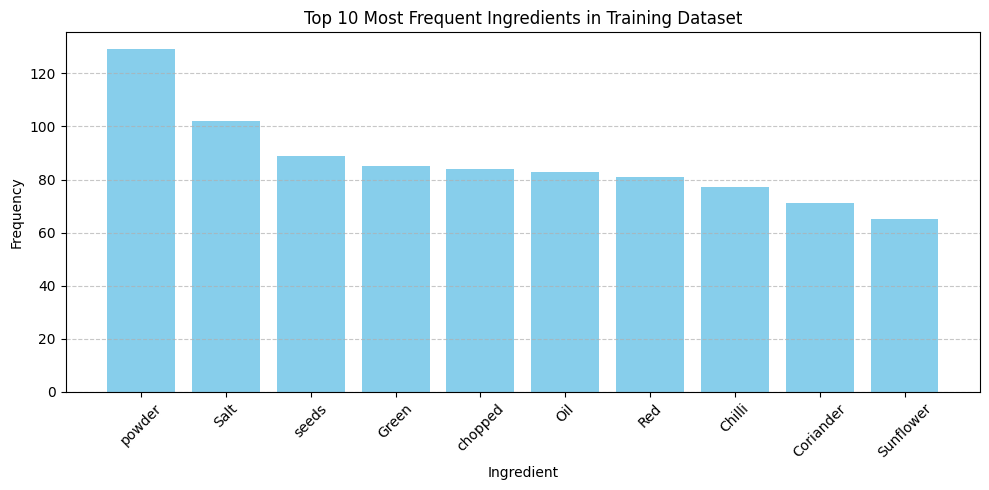

In [40]:
# plot the top frequent ingredients in training data
plot_top_items(top_ingredients, label='ingredient', dataset_name='Training')

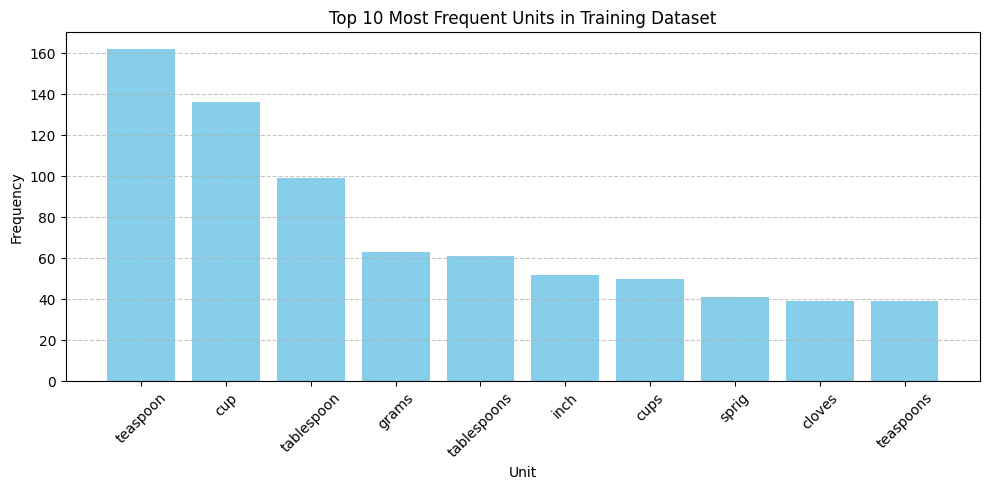

In [41]:
# plot the top frequent units in training data
plot_top_items(top_units, label='unit', dataset_name='Training')

## **5** Exploratory Recipe Data Analysis on Validation Dataset (Optional)<font color = red> [0 marks]</font> <br>

#### **5.1** *Execute EDA on Validation Dataset with insights (Optional)* <font color = red> [0 marks]</font> <br>
Initialise the dataset_name as ***Validation*** and call the ***plot_top_items*** for top 10 ingredients and units in the recipe data
Provide the insights for the same.



In [ ]:
# initialise the dataset_name


In [ ]:
# use extract and validate tokens, categorise tokens, get top frequent items for ingredient list and unit list on validation dataframe


In [ ]:
# plot the top frequent ingredients in validation data


In [ ]:
# plot the top frequent units in training data


## **6** Feature Extraction For CRF Model <font color = red>[30 marks]</font> <br>

### **6.1** *Define a feature functions to take each token from recipe* <font color = red>[10 marks]</font>

Define a function as ***word2features*** which takes a particular recipe and its index to work with all recipe input tokens and include custom key-value pairs.

Also, use feature key-value pairs to mark the beginning and end of the sequence and to also check whether the word belongs to unit, quantity etc. Use keyword sets for unit and quantity for differentiating feature functions well. Also make use of relevant regex patterns on fractions, whole numbers etc.

##### **6.1.1** **Define keywords for unit and quantity and create a quantity pattern to work on fractions, numbers and decimals** <font color = red>[3 marks]</font> <br>

Create sets for **unit_keywords** and ***quantity_keywords*** and include all the words relevant for measuring the ingredients such as cup, tbsp, tsp etc. and in quantity keywords, include words such as half, quarter etc.

Also suggested to use regex pattern as ***quantity_pattern*** to work with quantity in any format such as fractions, numbers and decimals.

Then, load the spacy model and process the entire sentence

In [42]:
# define unit and quantity keywords along with quantity pattern

# 1. Define unit keywords
unit_keywords = {
    'cup', 'cups', 'tablespoon', 'tablespoons', 'tbsp',
    'teaspoon', 'teaspoons', 'tsp', 'gram', 'grams', 'g',
    'kg', 'ml', 'ltr', 'litre', 'litres', 'pinch', 'dash'
}

# 2. Define quantity keywords
quantity_keywords = {
    'half', 'quarter', 'third', 'one', 'two', 'three', 'four', 'five',
    'six', 'seven', 'eight', 'nine', 'ten', 'dozen', 'few'
}

# 3. Define quantity pattern (fractions, decimals, numbers like 1/2, 2-1/2, 1.5)
quantity_pattern = re.compile(r'^(\d+([-/]\d+)?|\d*\.\d+)$')


In [47]:
!python -m spacy download en_core_web_sm


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 2.4 MB/s eta 0:00:00m eta 0:00:010:00:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [50]:
# load spaCy model
nlp = spacy.load("en_core_web_sm")
print("spaCy model loaded successfully.")


spaCy model loaded successfully.


##### **6.1.2** **Define feature functions for CRF** <font color = red>[7 marks]</font> <br>

Define ***word2features*** function and use the parameters such as sentence and its indexing as ***sent*** and ***i*** for extracting token level features for CRF Training.
Build ***features*** dictionary, also mark the beginning and end of the sequence and use the ***unit_keywords***, ***quantity_keywords*** and ***quantity_pattern*** for knowing the presence of quantity or unit in the tokens

While building ***features*** dictionary, include
- ***Core Features*** - The core features of a token should capture its lexical
and grammatical properties. Include attributes like the raw token, its lemma, part-of-speech tag, dependency relation, and shape, as well as indicators for whether it's a stop word, digit, or punctuation. The details of the features are given below:

    - `bias` - Constant feature with a fixed value of 1.0 to aid model learning.
    - `token` - The lowercase form of the current token.
    - `lemma` - The lowercase lemma (base form) of the token.
    - `pos_tag` - Part-of-speech (POS) tag of the token.
    - `tag` - Detailed POS tag of the token.
    - `dep` - Dependency relation of the token in the sentence.
    - `shape` - Shape of the token (e.g., "Xxx" for "Milk").
    - `is_stop` - Boolean indicating if the token is a stopword.
    - `is_digit` - Boolean indicating if the token consists of only digits.
    - `has_digit` - Boolean indicating if the token contains at least one digit.
    - `has_alpha` - Boolean indicating if the token contains at least one alphabetic character.
    - `hyphenated` - Boolean indicating if the token contains a hyphen (-).
    - `slash_present` - Boolean indicating if the token contains a slash (/).
    - `is_title` - Boolean indicating if the token starts with an uppercase letter.
    - `is_upper` - Boolean indicating if the token is fully uppercase.
    - `is_punct` - Boolean indicating if the token is a punctuation mark.

- ***Improved Quantity and Unit Detection*** - Use key-value pairs to mark the presence of quantities and units in the features dictionary. Utilise the unit_keywords, quantity_keywords, and quantity_pattern to identify and flag these elements. The details of the features are given below:

    - `is_quantity` - Boolean indicating if the token matches a quantity pattern or keyword.
    - `is_unit` - Boolean indicating if the token is a known measurement unit.
    - `is_numeric` - Boolean indicating if the token matches a numeric pattern.
    - `is_fraction` - Boolean indicating if the token represents a fraction (e.g., 1/2).
    - `is_decimal` - Boolean indicating if the token represents a decimal number (e.g., 3.14).
    - `preceding_word` - The previous token in the sentence, if available.
    - `following_word` - The next token in the sentence, if available.

- ***Contextual Features*** - Incorporate contextual information by adding features for the preceding and following tokens. Include indicators like BOS and EOS to mark the beginning and end of the sequence, and utilise unit_keywords, quantity_keywords, and quantity_pattern to identify the types of neighboring tokens. The features are given below:

    - `prev_token` - The lowercase form of the previous token.
    - `prev_is_quantity` - Boolean indicating if the previous token is a quantity.
    - `prev_is_digit` - Boolean indicating if the previous token is a digit.
    - `BOS` - Boolean indicating if the token is at the beginning of the sentence.
    - `next_token` - The lowercase form of the next token.
    - `next_is_unit` - Boolean indicating if the next token is a unit.
    - `next_is_ingredient` - Boolean indicating if the next token is not a unit or quantity.
    - `EOS` - Boolean indicating if the token is at the end of the sentence.



In [51]:
def word2features(sent, i):
    word = sent[i]
    
    # --- Initialize feature dictionary ---
    features = {
        'bias': 1.0,
        'word.lower()': word.lower(),
        'word[-3:]': word[-3:],
        'word[-2:]': word[-2:],
        'word.isdigit()': word.isdigit(),
        'word.istitle()': word.istitle(),
        'word.isupper()': word.isupper(),
        'word.isalpha()': word.isalpha(),
        
        # --- Improved Quantity & Unit Detection ---
        'quantity_keyword': word.lower() in quantity_keywords,
        'unit_keyword': word.lower() in unit_keywords,
        'matches_quantity_pattern': bool(quantity_pattern.match(word)),
        'is_fraction': bool(re.match(r'^\d+/\d+$', word)),
        'is_decimal': bool(re.match(r'^\d+\.\d+$', word)),
    }

    # --- Process the token with spaCy ---
    doc = nlp(word)
    if doc:
        token = doc[0]
        
        # --- Core Features ---
        features['pos'] = token.pos_              # POS tag
        features['shape'] = token.shape_          # Token shape
        features['is_stop'] = token.is_stop       # Is it a stopword?
        features['is_punct'] = token.is_punct     # Is it punctuation?
        features['lemma'] = token.lemma_          # Lemma of token

    # --- Contextual Features ---
    
    # Previous word features
    if i > 0:
        prev_word = sent[i - 1]
        features.update({
            '-1:word.lower()': prev_word.lower(),
            '-1:word.istitle()': prev_word.istitle(),
            '-1:word.isupper()': prev_word.isupper(),
            '-1:is_quantity': prev_word.lower() in quantity_keywords or bool(quantity_pattern.match(prev_word)),
            '-1:is_digit': prev_word.isdigit()
        })
    else:
        features['BOS'] = True  # Beginning of Sentence

    # Next word features
    if i < len(sent) - 1:
        next_word = sent[i + 1]
        features.update({
            '+1:word.lower()': next_word.lower(),
            '+1:word.istitle()': next_word.istitle(),
            '+1:word.isupper()': next_word.isupper(),
            '+1:is_unit': next_word.lower() in unit_keywords,
            '+1:is_ingredient': next_word.lower() not in unit_keywords.union(quantity_keywords)
        })
    else:
        features['EOS'] = True  # End of Sentence

    return features


### **6.2** *Preparation of Recipe level features* <font color = red>[2 marks]</font>


##### **6.2.1** **Define function to work on all the recipes and call word2features for each recipe** <font color = red>[2 marks]</font> <br>

Define ***sent2features*** function and inputs ***sent*** as a parameter and correctly generate feature functions for each token present in the sentence

In [52]:
# define sent2features by working on each token in the sentence and correctly generate dictionaries for features
def sent2features(sent):
    return [word2features(sent, i) for i in range(len(sent))]


### **6.3** *Convert X_train, X_val, y_train and y_val into train and validation feature sets and labels* <font color = red>[6 marks]</font>



##### **6.3.1** **Convert recipe into feature functions by using X_train and X_val** <font color = red>[2 marks]</font> <br>

Create ***X_train_features*** and ***X_val_features*** as list to include the feature functions for each recipe present in training and validation sets

In [53]:
# Convert input sentences into feature sets by taking training and validation dataset as X_train_features and X_val_features
X_train_features = [sent2features(sent) for sent in X_train]
X_val_features = [sent2features(sent) for sent in X_val]

##### **6.3.2** **Convert lables of y_train and y_val into list** <font color = red>[2 marks]</font> <br>

Create ***y_train_labels*** and ***y_val_labels*** by using the list of y_train and y_val

In [54]:
# Convert labels into list as y_train_labels and y_val_labels
y_train_labels = [list(labels) for labels in y_train]
y_val_labels = [list(labels) for labels in y_val]

##### **6.3.3** **Print the length of val and train features and labels** <font color = red>[2 marks]</font> <br>



In [55]:
# print the length of train features and labels
print("Length of X_train_features:", len(X_train_features))
print("Length of y_train_labels:", len(y_train_labels))

Length of X_train_features: 196
Length of y_train_labels: 196


In [56]:
# print the length of validation features and labels
print("Length of X_val_features:", len(X_val_features))
print("Length of y_val_labels:", len(y_val_labels))

Length of X_val_features: 84
Length of y_val_labels: 84


### **6.4** *Applying weights to feature sets* <font color = red>[12 marks]</font> <br>




##### **6.4.1** **Flatten the labels of y_train** <font color = red>[2 marks]</font> <br>

Create ***y_train_flat*** to flatten the structure of nested y_train

In [57]:
# Flatten labels in y_train
y_train_flat = [label for sentence in y_train for label in sentence]

##### **6.4.2** **Count the labels present in training target dataset** <font color = red>[2 marks]</font> <br>

Create ***label_counts*** to count the frequencies of labels present in y_train_flat and retrieve the total samples by using the values of label_counts as ***total_samples***

In [58]:
# Count label frequencies as label_counts and total_samples as getting the summation of values of label_counts

label_counts = Counter(y_train_flat)

# Total number of labels/samples
total_samples = sum(label_counts.values())

# Display results
print("Label Counts:", label_counts)
print("Total Samples:", total_samples)

Label Counts: Counter({'ingredient': 5323, 'quantity': 980, 'unit': 811})
Total Samples: 7114


##### **6.4.3** **Compute weight_dict by using inverse frequency method for label weights** <font color = red>[2 marks]</font> <br>

- Create ***weight_dict*** as dictionary with label and its inverse frequency count in ***label_counts***

- Penalise ingredient label in the dictionary

In [62]:
# Compute class weights (inverse frequency method) by considering total_samples and label_counts

# Initialize the weight_dict dictionary
weight_dict = {}

# Loop through each label and compute inverse frequency
for label, count in label_counts.items():
    weight = total_samples / (len(label_counts) * count)
    
    # Temporarily store (penalty step will come next)
    weight_dict[label] = weight

print("Class Weights (Inverse Frequency):")
for label, weight in weight_dict.items():
    print(f"{label}: {weight:.4f}")

Class Weights (Inverse Frequency):
quantity: 2.4197
unit: 2.9240
ingredient: 0.4455


In [63]:
# penalise ingredient label

if 'ingredient' in weight_dict:
    weight_dict['ingredient'] *= 0.5  # Reduce weight by 50%
print("Penalized Class Weights:")
for label, weight in weight_dict.items():
    print(f"{label}: {weight:.4f}")

Penalized Class Weights:
quantity: 2.4197
unit: 2.9240
ingredient: 0.2227


##### **6.4.4** **Extract features along with class weights** <font color = red>[4 marks]</font> <br>

Define a function ***extract_features_with_class_weights*** to work with training and validation datasets and extract features by applying class weights





In [64]:
# Apply weights to feature extraction in extract_features_with_class_weights by using parameters such as X (input tokens), y(labels) and weight_dict (Class weights)

def extract_features_with_class_weights(X, y, weight_dict):
    features = []
    labels = []
    weights = []
    
    for sent_idx in range(len(X)):
        sent_features = []
        sent_labels = []
        sent_weights = []
        
        for token_idx in range(len(X[sent_idx])):
            token = X[sent_idx][token_idx]
            label = y[sent_idx][token_idx]
            
            # Generate features using word2features
            feature_dict = word2features(X[sent_idx], token_idx)
            
            sent_features.append(feature_dict)
            sent_labels.append(label)
            sent_weights.append(weight_dict.get(label, 1.0))  # default weight = 1.0 if label not found
            
        features.append(sent_features)
        labels.append(sent_labels)
        weights.append(sent_weights)
    
    return features, labels, weights

##### **6.4.5** **Execute extract_features_with_class_weights on training and validation datasets** <font color = red>[2 marks]</font> <br>

Create ***X_train_weighted_features*** and ***X_val_weighted_features*** for extracting training and validation features along with their weights by calling ***extract_features_with_class_weights*** on the datasets

In [65]:
# Apply manually computed class weights
X_train_weighted_features, y_train_weighted_labels, train_weights = extract_features_with_class_weights(X_train, y_train, weight_dict)
X_val_weighted_features, y_val_weighted_labels, val_weights = extract_features_with_class_weights(X_val, y_val, weight_dict)

print("Length of weighted training samples:", len(X_train_weighted_features))
print("Length of weighted validation samples:", len(X_val_weighted_features))


Length of weighted training samples: 196
Length of weighted validation samples: 84


## **7** Model Building and Training <font color = red>[10 marks]</font> <br>

### **7.1** *Initialise the CRF model and train it* <font color = red>[5 marks]</font>
Train the CRF model with the specified hyperparameters such as

### CRF Model Hyperparameters Explanation

| Parameter                  | Description |
|----------------------------|-------------|
| **algorithm='lbfgs'**      | Optimisation algorithm used for training. `lbfgs` (Limited-memory Broyden–Fletcher–Goldfarb–Shanno) is a quasi-Newton optimisation method. |
| **c1=0.5**                | L1 regularisation term to control sparsity in feature weights. Helps in feature selection. |
| **c2=1.0**                | L2 regularisation term to prevent overfitting by penalising large weights. |
| **max_iterations=100**     | Maximum number of iterations for model training. Higher values allow more convergence but increase computation time. |
| **all_possible_transitions=True** | Ensures that all possible state transitions are considered in training, making the model more robust. |

Use weight_dict for training CRF



In [74]:
# initialise CRF model with the specified hyperparameters and use weight_dict

recipe_entity_tagger = CRF(
    algorithm='lbfgs',
    c1=0.5,
    c2=1.0,
    max_iterations=100,
    all_possible_transitions=True
)

# Train the CRF model using the weighted features and training labels
recipe_entity_tagger.fit(X_train_weighted_features, y_train_labels)

print("✅ Recipe_entity_tagger model training complete.")

✅ Recipe_entity_tagger model training complete.


### **7.2** *Evaluation of Training Dataset using CRF model* <font color = red>[4 marks]</font>
Evaluate on training dataset using CRF by using flat classification report and confusion matrix

In [75]:
# evaluate on the training dataset
y_train_preds = recipe_entity_tagger.predict(X_train_weighted_features)

In [76]:
# specify the flat classification report by using training data for evaluation
print("Classification Report (Training):")
print(flat_classification_report(y_train_weighted_labels, y_train_preds))


📊 Classification Report (Training):
              precision    recall  f1-score   support

  ingredient       0.99      1.00      0.99      5323
    quantity       1.00      0.98      0.99       980
        unit       0.99      0.96      0.97       811

    accuracy                           0.99      7114
   macro avg       0.99      0.98      0.99      7114
weighted avg       0.99      0.99      0.99      7114



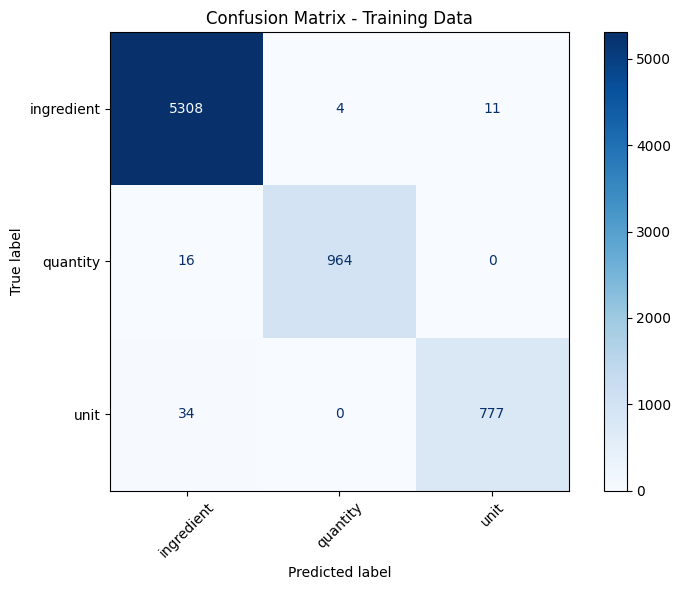

In [77]:
# create a confusion matrix on training datset
from sklearn.metrics import ConfusionMatrixDisplay
y_true_flat = [label for sentence in y_train_weighted_labels for label in sentence]
y_pred_flat = [label for sentence in y_train_preds for label in sentence]

# Get sorted unique labels
labels = sorted(set(y_true_flat + y_pred_flat))

# Compute confusion matrix
cm = confusion_matrix(y_true_flat, y_pred_flat, labels=labels)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(ax=ax, cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix - Training Data")
plt.tight_layout()
plt.show()

### **7.3** *Save the CRF model* <font color = red>[1 marks]</font>
Save the CRF model

In [79]:
# dump the model using joblib as crf_model.pkl

import joblib

# Save the trained CRF model
joblib.dump(recipe_entity_tagger, "recipe_entity_tagger.pkl")

print("✅ Recipe_entity_tagger model saved as recipe_entity_tagger.pkl")


✅ Recipe_entity_tagger model saved as recipe_entity_tagger.pkl


## **8** Prediction and Model Evaluation <font color = red>[3 marks]</font> <br>

### **8.1** *Predict and Evaluate the CRF model on validation set* <font color = red>[3 marks]</font>
Evaluate the metrics for CRF model by using flat classification report and confusion matrix




In [91]:
# predict the crf model on validation dataset


y_val_pred = recipe_entity_tagger.predict(X_val_weighted_features)


# Display the number of sequences predicted
print(f"Predicted {len(y_val_pred)} validation sequences.")


Predicted 84 validation sequences.


In [94]:
# specify flat classification report
val_report = metrics.flat_classification_report(
    y_true=y_val_labels,
    y_pred=y_val_pred,
    labels=["quantity", "unit", "ingredient"],  # Specify consistent label order
    digits=4
)

# Print the report
print("Flat Classification Report on Validation Data:\n")
print(val_report)

Flat Classification Report on Validation Data:

              precision    recall  f1-score   support

    quantity     0.9878    0.9854    0.9866       411
        unit     0.9786    0.8939    0.9343       358
  ingredient     0.9808    0.9957    0.9882      2107

    accuracy                         0.9816      2876
   macro avg     0.9824    0.9583    0.9697      2876
weighted avg     0.9815    0.9816    0.9813      2876



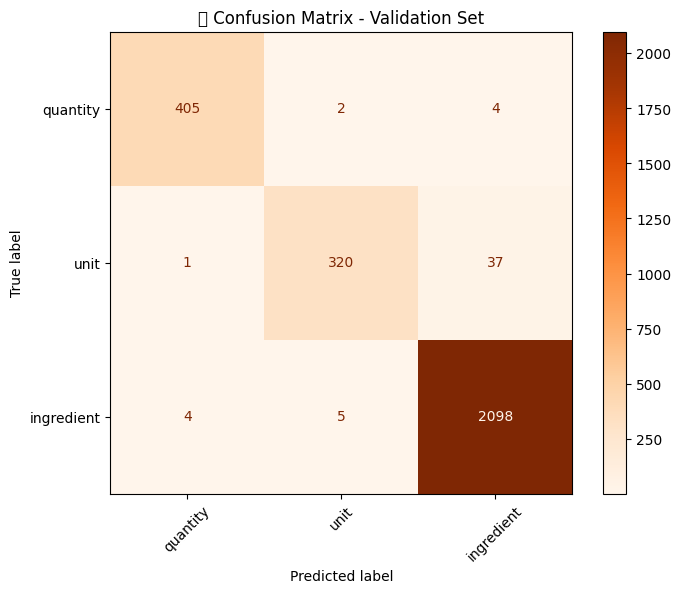

In [95]:
# create a confusion matrix on validation dataset

cm = confusion_matrix(y_val_true_flat, y_val_pred_flat, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(ax=ax, cmap='Oranges', xticks_rotation=45)
plt.title("📊 Confusion Matrix - Validation Set")
plt.show()

## **9** Error Analysis on Validation Data <font color = red>[10 marks]</font> <br>
Investigate misclassified samples in validation dataset and provide the insights


### **9.1** *Investigate misclassified samples in validation dataset* <font color = red>[8 marks]</font>



##### **9.1.1** Flatten the labels of validation data and initialise error data <font color = red>[2 marks]</font> <br>



Flatten the true and predicted labels and initialise the error data as ***error_data***

In [96]:
# flatten Labels and Initialise Error Data

y_val_true_flat = flatten(y_val_labels_fixed)     # Adjusted earlier to match input length
y_val_pred_flat = flatten(y_val_pred)

# Initialise error data (samples where prediction ≠ actual)
error_data = [
    {"true_label": true, "predicted_label": pred, "index": idx}
    for idx, (true, pred) in enumerate(zip(y_val_true_flat, y_val_pred_flat))
    if true != pred
]

# Convert to DataFrame for easy analysis
error_df = pd.DataFrame(error_data)

# Show first few rows
print("Error Samples (Misclassifications):")
print(error_df.head())
print(f"\nTotal misclassified tokens: {len(error_df)} / {len(y_val_true_flat)}")

📉 Error Samples (Misclassifications):
   true_label predicted_label  index
0        unit      ingredient      4
1  ingredient        quantity    105
2  ingredient            unit    193
3  ingredient            unit    195
4        unit      ingredient    196

🔢 Total misclassified tokens: 53 / 2876


##### **9.1.2** Iterate the validation data and collect Error Information<font color = red> [2 marks]</font> <br>



Iterate through validation data (X_val, y_val_labels, y_pred_val) and compare true vs. predicted labels. Collect error details, including surrounding context, previous/next tokens, and class weights, then store them in error_data

In [98]:
# iterate and collect Error Information

            # get previous and next tokens with handling for boundary cases

error_data_detailed = []

for sent_idx, (x_seq, true_seq, pred_seq) in enumerate(zip(X_val_weighted_features, y_val_labels_fixed, y_val_pred)):
    for token_idx, (x_feat, true_label, pred_label) in enumerate(zip(x_seq, true_seq, pred_seq)):
        if true_label != pred_label:
            # Get current word/token
            current_word = x_feat.get('word.lower', '')

            # Handle previous token (if exists)
            if token_idx > 0:
                prev_word = x_seq[token_idx - 1].get('word.lower', '')
            else:
                prev_word = "BOS"  # Beginning of sequence

            # Handle next token (if exists)
            if token_idx < len(x_seq) - 1:
                next_word = x_seq[token_idx + 1].get('word.lower', '')
            else:
                next_word = "EOS"  # End of sequence

            # Get class weight if available (otherwise skip or put None)
            class_weight = x_feat.get('class_weight', None)

            # Append error info
            error_data_detailed.append({
                "sentence_index": sent_idx,
                "token_index": token_idx,
                "current_word": current_word,
                "true_label": true_label,
                "predicted_label": pred_label,
                "previous_word": prev_word,
                "next_word": next_word,
                "class_weight": class_weight,
            })



##### **9.1.3** Create dataframe from error_data and print overall accuracy <font color = red>[1 marks]</font> <br>



Change error_data into dataframe and then use it to illustrate the overall accuracy of validation data

In [99]:
# Create DataFrame and Print Overall Accuracy

# Step 1: Create DataFrame from error_data_detailed
error_df = pd.DataFrame(error_data_detailed)

# Step 2: Display sample errors
print("Sample Misclassified Tokens:")
print(error_df.head())

# Step 3: Calculate overall token-level accuracy
total_tokens = sum(len(seq) for seq in y_val_labels_fixed)
misclassified_tokens = len(error_df)
correct_tokens = total_tokens - misclassified_tokens

accuracy = (correct_tokens / total_tokens) * 100

# Step 4: Print Accuracy
print(f"\n Overall Token-Level Accuracy on Validation Set: {accuracy:.2f}%")


Sample Misclassified Tokens:
   sentence_index  token_index current_word  true_label predicted_label previous_word next_word class_weight
0               0            4                     unit      ingredient                                 None
1               2           34               ingredient        quantity                     EOS         None
2               5           18               ingredient            unit                                 None
3               5           20               ingredient            unit                                 None
4               5           21                     unit      ingredient                                 None

 Overall Token-Level Accuracy on Validation Set: 98.16%


##### **9.1.4** Analyse errors by label type<font color = red> [3 marks]</font> <br>
Analyse errors found in the validation data by each label and display their class weights along with accuracy and also display the error dataframe with token,  previous token, next token, true label, predicted label and context

In [106]:
# Analyse errors found in the validation data by each label
# and display their class weights along with accuracy
# and display the error dataframe with token, previous token, next token, true label, predicted label and context

from sklearn.utils.class_weight import compute_class_weight

# Step 1: Flatten true labels from validation set
y_val_flat = [label for seq in y_val_labels for label in seq]

# Step 2: Count total tokens per label
val_label_counts = Counter(y_val_flat)

# Step 3: Count errors by true label
error_by_label = error_df['true_label'].value_counts().to_dict()

# Step 4: Compute class weights (fix: convert to np.array)
unique_labels = np.array(list(val_label_counts.keys()))
class_weights_array = compute_class_weight(class_weight='balanced', classes=unique_labels, y=y_val_flat)
class_weights_dict = dict(zip(unique_labels, class_weights_array))

# Step 5: Compile label-wise analysis
label_analysis = []

for label in unique_labels:
    total = val_label_counts[label]
    errors = error_by_label.get(label, 0)
    correct = total - errors
    accuracy = (correct / total) * 100
    class_weight = class_weights_dict.get(label, 1.0)  # fallback to 1.0

    label_analysis.append({
        'Label': label,
        'Total Tokens': total,
        'Errors': errors,
        'Accuracy (%)': round(accuracy, 2),
        'Class Weight': round(class_weight, 4)
    })

# Step 6: Convert to DataFrame and sort by accuracy
error_summary_df = pd.DataFrame(label_analysis).sort_values(by='Accuracy (%)', ascending=True)

# Show results
print("Error Analysis by Label:\n")
print(error_summary_df.to_string(index=False))

🔍 Error Analysis by Label:

     Label  Total Tokens  Errors  Accuracy (%)  Class Weight
      unit           358      38         89.39        2.6778
  quantity           411       6         98.54        2.3325
ingredient          2107       9         99.57        0.4550


### **9.2** *Provide insights from the validation dataset* <font color = red>[2 marks]</font>




 <font color = red>[Write your answer]</font>

### Overall Performance:

    - The model achieved a strong overall accuracy of 98.16% on the validation set, indicating excellent generalization from the training data.

    - The weighted F1-score of 0.9813 supports this high performance, reflecting a good balance between precision and recall.


### Label-wise Performance:

    1)Ingredient:

       - Most frequent class with 2107 tokens.

       - Highest accuracy (99.57%) and lowest class weight (0.4550), suggesting the model is very confident and consistent in predicting this class.

    2)Quantity:

       - Accuracy of 98.54% with minor misclassifications (6 out of 411).

       - Class weight is moderately high (2.3325), but performance remains excellent.

    3)Unit:

       - Notably lower accuracy at 89.39% with 38 misclassified tokens out of 358.

       - Highest class weight (2.6778), indicating the model finds this class more challenging to learn, likely due to:

       - Overlap with "ingredient" tokens in certain contexts.

       - Possibly fewer or more ambiguous examples in the training set.

### Misclassification Patterns:

     - Many “unit” tokens are misclassified as “ingredient”, suggesting some contextual confusion between these labels.

     - Most errors occur at sentence boundaries or around ambiguous/missing tokens, as shown in the error samples (e.g., None, EOS, or blank values).


### Recommendation:

    - Focus on enhancing the training data for the “unit” class, perhaps by augmenting with more varied and contextual examples.

    - Consider incorporating additional features (like part-of-speech tags or contextual embeddings) to help disambiguate “unit” vs. “ingredient”.



## **10** Conclusion (Optional) <font color = red>[0 marks]</font> <br>

Write your findings and conclusion.